# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 1

### Introdução

Em projetos de ciência de dados visando a construção de modelos de *machine learning*, ou aprendizado estatístico, é muito incomum que os dados iniciais estejam já no formato ideal para a construção de modelos. São necessários vários passos intermediários de pré-processamento de dados, como por exemplo a codificação de variáveis categóricas, normalização de variáveis numéricas, tratamento de dados faltantes, etc. A biblioteca **scikit-learn** -- uma das mais populares bibliotecas de código-aberto para *machine learning* no mundo -- possui diversas funções já integradas para a realização das transformações de dados mais utilizadas. Entretanto, em um fluxo comum de um modelo de aprendizado de máquina, é necessária a aplicação dessas transformações pelo menos duas vezes: a primeira vez para "treinar" o modelo, e depois novamente quando novos dados forem enviados como entrada para serem classificados por este modelo. 

Para facilitar o trabalho com esse tipo de fluxo, o scikit-learn possui também uma ferramenta chamada **Pipeline**, que nada mais é do que uma lista ordenada de transformações que devem ser aplicadas nos dados. Para auxiliar no desenvolvimento e no gerenciamento de todo o ciclo-de-vida dessas aplicações, alem do uso de Pipelines, as equipes de cientistas de dados podem utilizar em conjunto o **Watson Machine Learning**, que possui dezenas de ferramentas para treinar, gerenciar, hospedar e avaliar modelos baseados em aprendizado de máquina. Além disso, o Watson Machine Learning é capaz de encapsular pipelines e modelos em uma API pronta para uso e integração com outras aplicações.

Durante o desafio 2, você participante irá aprender a construir uma **Pipeline** para um modelo de classificação e hospedá-lo como uma API com o auxílio do Watson Machine Learning. Uma vez hospedado, você poderá integrar o modelo criado com outras aplicações, como assistentes virtuais e muito mais. Neste notebook, será apresentado um exemplo funcional de criação de um modelo e de uma pipeline no scikit-learn (que você poderá utilizar como template para a sua solução!).

### Trabalhando com Pipelines do scikit-learn

In [ ]:
# Primeiro, realizamos a instalação do scikit-learn versão 0.20.0 no Kernel deste notebook:
!pip install scikit-learn==0.20.0 --upgrade

In [87]:
# Em seguida iremos importar diversas bibliotecas que serão utilizadas:

# Pacote para trabalhar com JSON
import json

# Pacote para realizar requisições HTTP
import requests

# Pacote para exploração e análise de dados
import pandas as pd

# Pacote com métodos numéricos e representações matriciais
import numpy as np

# Pacote para construção de modelo baseado na técnica Gradient Boosting
import xgboost as xgb

# Pacotes do scikit-learn para pré-processamento de dados
# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Pacotes do scikit-learn para treinamento de modelos e construção de pipelines
# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split
# Método para criação de modelos baseados em árvores de decisão
from sklearn.tree import DecisionTreeClassifier
# Classe para a criação de uma pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Pacotes do scikit-learn para avaliação de modelos
# Métodos para validação cruzada do modelo criado
from sklearn.model_selection import KFold, cross_validate

### Importando um .csv de seu projeto no IBM Cloud Pak for Data para o Kernel deste notebook

Primeiro iremos importar o dataset fornecido para o desafio, que já está incluso neste projeto!

Você pode realizar a importação dos dados de um arquivo .csv diretamente para o Kernel do notebook como um DataFrame da biblioteca Pandas, muito utilizada para a manipulação de dados em Python.

Para realizar a importação, basta selecionar a próxima célula e seguir as instruções na imagem abaixo:

![alt text](https://i.imgur.com/K1DwL9I.png "importing-csv-as-df")

Após a seleção da opção **"Insert to code"**, a célula abaixo será preenchida com o código necessário para importação e leitura dos dados no arquivo .csv como um DataFrame Pandas.

In [116]:
df_data_1 = pd.read_csv("Data/dataset_desafio_2_modificado.csv")

Temos 15 colunas presentes no dataset fornecido, sendo dezessete delas variáveis características (dados de entrada) e um delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever). 

As variáveis características são:

    MATRICULA       - número de matrícula do estudante
    NOME            - nome completo do estudante
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    REPROVACOES_GO  - número de reprovações na disciplina de ``Gestão Operacional``
    NOTA_DE         - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    NOTA_EM         - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    NOTA_MF         - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    NOTA_GO         - média simples das notas do aluno na disciplina de ``Gestão Operacional`` (0-10)
    INGLES          - variável binária que indica se o estudante tem conhecimento em língua inglesa (0 -> sim ou 1 -> não).
    H_AULA_PRES     - horas de estudo presencial realizadas pelo estudante
    TAREFAS_ONLINE  - número de tarefas online entregues pelo estudante
    FALTAS          - número de faltas acumuladas do estudante (todas disciplinas)
    
A variável-alvo é:

    PERFIL               - uma *string* que indica uma de cinco possibilidades: 
        "EXCELENTE"      - Estudante não necessita de mentoria
        "MUITO BOM"      - Estudante não necessita de mentoria
        "HUMANAS"        - Estudante necessita de mentoria exclusivamente em matérias com conteúdo de ciências humanas
        "EXATAS"         - Estudante necessita de mentoria apenas em disciplinas com conteúdo de ciências exatas
        "DIFICULDADE"    - Estudante necessita de mentoria em duas ou mais disciplinas
        
Com um modelo capaz de classificar um estudante em uma dessas categorias, podemos automatizar parte da mentoria estudantil através de assistentes virtuais, que serão capazes de recomendar práticas de estudo e conteúdo personalizado com base nas necessidades de cada aluno.

### Explorando os dados fornecidos

Podemos continuar a exploração dos dados fornecidos com a função ``info()``:

In [117]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41150 entries, 0 to 41149
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MATRICULA       41150 non-null  int64  
 1   REPROVACOES_DE  41150 non-null  int64  
 2   REPROVACOES_EM  41150 non-null  int64  
 3   REPROVACOES_MF  41150 non-null  int64  
 4   REPROVACOES_GO  41150 non-null  int64  
 5   NOTA_DE         41150 non-null  float64
 6   NOTA_EM         41150 non-null  float64
 7   NOTA_MF         41150 non-null  float64
 8   NOTA_GO         41150 non-null  float64
 9   INGLES          41150 non-null  float64
 10  H_AULA_PRES     41150 non-null  int64  
 11  TAREFAS_ONLINE  41150 non-null  int64  
 12  FALTAS          41150 non-null  int64  
 13  PERFIL          41150 non-null  object 
 14  NOME            41150 non-null  object 
dtypes: float64(5), int64(8), object(2)
memory usage: 4.7+ MB


É notado que existem variáveis do tipo ``float64`` (números "decimais"), variáveis do tipo ``int64`` (números inteiros) e do tipo ``object`` (nesse caso são *strings*, ou texto). 

Como a maioria dos algoritmos de aprendizado estatístico supervisionado só aceita valores numéricos como entrada, é necessário então o pré-processamento das variáveis do tipo "object" antes de usar esse dataset como entrada para o treinamento de um modelo. Também é notado que existem valores faltantes em várias colunas. Esses valores faltantes também devem ser tratados antes de serem construídos modelos com esse conjunto de dados base.

A função ``describe()`` gera várias informações sobre as variáveis numéricas que também podem ser úteis:

In [118]:
df_data_1.describe()

,MATRICULA,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
count,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000,41150.000000
mean,550233.218323,0.130571,0.130620,0.160413,0.158931,6.079768,6.091801,6.214471,4.548540,0.455707,6.718445,3.466974,3.371543
std,260173.165785,0.461959,0.462734,0.510411,0.504147,2.167210,2.258985,2.652875,2.796644,0.457820,4.849450,1.769787,1.609367
min,100003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,323303.250000,0.000000,0.000000,0.000000,0.000000,6.000000,5.700000,5.400000,1.719239,0.000000,3.000000,2.000000,2.000000
50%,550489.000000,0.000000,0.000000,0.000000,0.000000,6.782868,6.800000,6.881979,5.600000,0.304844,5.000000,4.000000,3.000000
75%,775423.250000,0.000000,0.000000,0.000000,0.000000,7.301639,7.500000,7.970247,6.780196,1.000000,10.000000,5.000000,4.000000
max,999995.000000,3.000000,3.000000,3.000000,3.000000,9.000000,9.400000,11.500000,10.000000,1.000000,25.000000,7.000000,8.000000


### Visualizações

Para visualizar o dataset fornecido, podemos utilizar as bibliotecas ``matplotlib`` e ``seaborn``:

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

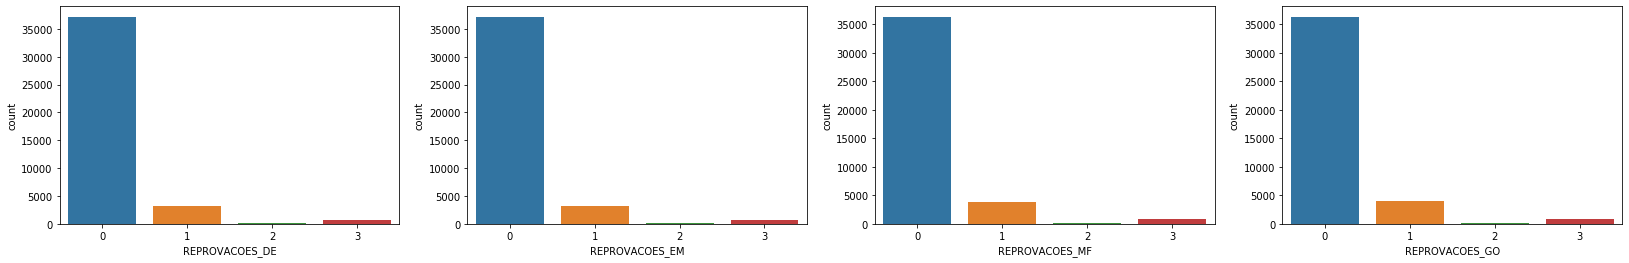

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='REPROVACOES_DE', data=df_data_1)
sns.countplot(ax=axes[1], x='REPROVACOES_EM', data=df_data_1)
sns.countplot(ax=axes[2], x='REPROVACOES_MF', data=df_data_1)
sns.countplot(ax=axes[3], x='REPROVACOES_GO', data=df_data_1)

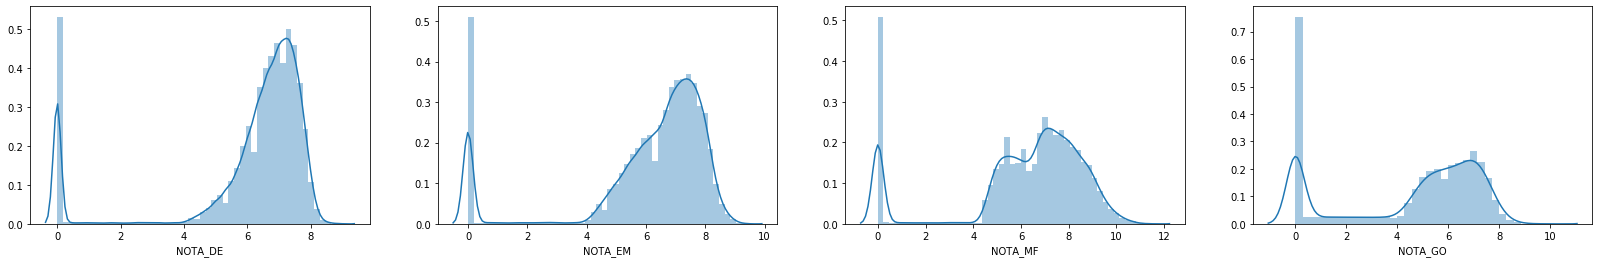

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.distplot(df_data_1['NOTA_DE'], ax=axes[0])
sns.distplot(df_data_1['NOTA_EM'], ax=axes[1])
sns.distplot(df_data_1['NOTA_MF'], ax=axes[2])
sns.distplot(df_data_1['NOTA_GO'].dropna(), ax=axes[3])

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='INGLES', data=df_data_1)
sns.countplot(ax=axes[1], x='FALTAS', data=df_data_1)
sns.countplot(ax=axes[2], x='H_AULA_PRES', data=df_data_1)
sns.countplot(ax=axes[3], x='TAREFAS_ONLINE', data=df_data_1)

Error in callback <function flush_figures at 0x0000021E01DD0288> (for post_execute):


KeyboardInterrupt: 

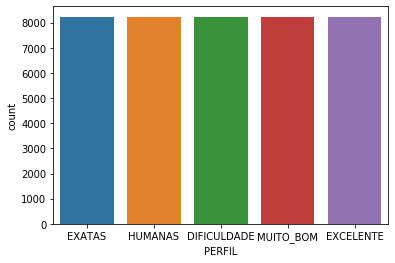

In [121]:
fig = plt.plot()
sns.countplot(x='PERFIL', data=df_data_1)

### Realizando o pré-processamento dos dados

Para o pré-processamento dos dados serão apresentadas duas transformações básicas neste notebook, demonstrando a construção de uma Pipeline com um modelo funcional. Esta Pipeline funcional fornecida deverá ser melhorada pelo participante para que o modelo final alcance a maior acurácia possível, garantindo uma pontuação maior no desafio. Essa melhoria pode ser feita apenas no pré-processamento dos dados, na escolha de um algoritmo para treinamento de modelo diferente, ou até mesmo na alteração do *framework* usado (entretanto só será fornecido um exemplo pronto de integração do Watson Machine Learning com o *scikit-learn*).

A primeira transformação (passo na nossa Pipeline) será a exclusão da coluna "NOME" do nosso dataset, que além de não ser uma variável numérica, também não é uma variável relacionada ao desempenho dos estudantes nas disciplinas. Existem funções prontas no scikit-learn para a realização dessa transformação, entretanto nosso exemplo irá demonstrar como criar uma transformação personalizada do zero no scikit-learn. Se desejado, o participante poderá utilizar esse exemplo para criar outras transformações e adicioná-las à Pipeline final :)

#### Transformação 1: excluindo colunas do dataset

Para a criação de uma transformação de dados personalizada no scikit-learn, é necessária basicamente a criação de uma classe com os métodos ``transform`` e ``fit``. No método transform será executada a lógica da nossa transformação.

Na próxima célula é apresentado o código completo de uma transformação ``DropColumns`` para a remoção de colunas de um DataFrame pandas.

In [122]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

Para aplicar essa transformação em um DataFrame pandas, basta instanciar um objeto *DropColumns* e chamar o método transform().

In [123]:
# Instanciando uma transformação DropColumns
rm_columns = DropColumns(
    columns=["NOME", "MATRICULA"]  # Essa transformação recebe como parâmetro uma lista com os nomes das colunas indesejadas
)

print(rm_columns)

DropColumns(columns=['NOME', 'MATRICULA'])


In [124]:
# Visualizando as colunas do dataset original
print("Colunas do dataset original: \n")
print(df_data_1.columns)

Colunas do dataset original: 

Index(['MATRICULA', 'REPROVACOES_DE', 'REPROVACOES_EM', 'REPROVACOES_MF',
       'REPROVACOES_GO', 'NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO', 'INGLES',
       'H_AULA_PRES', 'TAREFAS_ONLINE', 'FALTAS', 'PERFIL', 'NOME'],
      dtype='object')


In [125]:
# Aplicando a transformação ``DropColumns`` ao conjunto de dados base
rm_columns.fit(X=df_data_1)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_data_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_data_1
    ),
)

In [126]:
# Visualizando as colunas do dataset transformado
print("Colunas do dataset após a transformação ``DropColumns``: \n")
print(df_data_2.columns)

Colunas do dataset após a transformação ``DropColumns``: 

Index(['REPROVACOES_DE', 'REPROVACOES_EM', 'REPROVACOES_MF', 'REPROVACOES_GO',
       'NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO', 'INGLES', 'H_AULA_PRES',
       'TAREFAS_ONLINE', 'FALTAS', 'PERFIL'],
      dtype='object')


Nota-se que a coluna "NOME" foi removida e nosso dataset agora poossui apenas 17 colunas.

#### Transformação 2: tratando dados faltantes

Para tratar os dados faltantes em nosso conjunto de dados, iremos agora utilizar uma transformação pronta da biblioteca scikit-learn, chamada **SimpleImputer**.

Essa transformação permite diversas estratégias para o tratamento de dados faltantes. A documentação oficial pode ser encontrada em: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Neste exemplo iremos simplesmente transformar todos os valores faltantes em zero.

In [127]:
# Criação de um objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
    verbose=0,
    copy=True
)

In [128]:
# Visualizando os dados faltantes do dataset após a primeira transformação (df_data_2)
print("Valores nulos antes da transformação SimpleImputer: \n\n{}\n".format(df_data_2.isnull().sum(axis = 0)))

Valores nulos antes da transformação SimpleImputer: 

REPROVACOES_DE    0
REPROVACOES_EM    0
REPROVACOES_MF    0
REPROVACOES_GO    0
NOTA_DE           0
NOTA_EM           0
NOTA_MF           0
NOTA_GO           0
INGLES            0
H_AULA_PRES       0
TAREFAS_ONLINE    0
FALTAS            0
PERFIL            0
dtype: int64



In [130]:
# Aplicamos o SimpleImputer ``si`` ao conjunto de dados df_data_2 (resultado da primeira transformação)
si.fit(X=df_data_2)

# Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_3)
df_data_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_data_2
    ),  # o resultado SimpleImputer.transform(<<pandas dataframe>>) é lista de listas
    columns=df_data_2.columns  # as colunas originais devem ser conservadas nessa transformação
)

In [131]:
# Visualizando os dados faltantes do dataset após a segunda transformação (SimpleImputer) (df_data_3)
print("Valores nulos no dataset após a transformação SimpleImputer: \n\n{}\n".format(df_data_3.isnull().sum(axis = 0)))

Valores nulos no dataset após a transformação SimpleImputer: 

REPROVACOES_DE    0
REPROVACOES_EM    0
REPROVACOES_MF    0
REPROVACOES_GO    0
NOTA_DE           0
NOTA_EM           0
NOTA_MF           0
NOTA_GO           0
INGLES            0
H_AULA_PRES       0
TAREFAS_ONLINE    0
FALTAS            0
PERFIL            0
dtype: int64



In [132]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
    "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_data_3[features]
y = df_data_3[target]

Nota-se que não temos mais nenhum valor faltante no nosso conjunto de dados :)

Vale salientar que nem sempre a alteração dos valores faltantes por 0 é a melhor estratégia. O participante é incentivado a estudar e implementar estratégias diferentes de tratamento dos valores faltantes para aprimorar seu modelo e melhorar sua pontuação final.

### Treinando um modelo de classificação

Finalizado o pré-processamento, já temos o conjunto de dados no formato necessário para o treinamento do nosso modelo:

In [133]:
df_data_3.head()

,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


No exemplo fornecido, iremos utilizar todas as colunas, exceto a coluna **LABELS** como *features* (variáveis de entrada).

A variável **LABELS** será a variável-alvo do modelo, conforme descrito no enunciado do desafio.

#### Definindo as features do modelo

O conjunto de entrada (X):

In [135]:
X.head()

,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5


As variáveis-alvo correspondentes (y):

In [136]:
y.head()

,PERFIL
0,EXATAS
1,EXATAS
2,HUMANAS
3,DIFICULDADE
4,DIFICULDADE


#### Separando o dataset em um conjunto de treino e um conjunto de teste

Iremos separar o dataset fornecido em dois grupos: um para treinar nosso modelo, e outro para testarmos o resultado através de um teste cego. A separação do dataset pode ser feita facilmente com o método *train_test_split()* do scikit-learn:

In [99]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [137]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Criando um modelo baseado em árvores de decisão

No exemplo fornecido iremos criar um classificador baseado em **árvores de decisão**.

O primeiro passo é basicamente instanciar um objeto *DecisionTreeClassifier()* da biblioteca scikit-learn.

In [138]:
# Criação da árvore de decisão com a biblioteca ``scikit-learn``:
dtc_model = xgb.XGBClassifier()  # O modelo será criado com os parâmetros padrões da biblioteca

Material teórico sobre árvores de decisão na documentação oficial do scikit-learn: https://scikit-learn.org/stable/modules/tree.html

Um guia para iniciantes no mundo do machine learning: https://developer.ibm.com/br/articles/cc-beginner-guide-machine-learning-ai-cognitive/

#### Execução do evento de treino de uma árvore de decisão

In [139]:
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
dtc_model.fit(
    X_train,
    y_train
)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Execução de predições e avaliação do modelo criado

In [140]:
# Realização de teste cego no modelo criado
y_pred = dtc_model.predict(X_test)

In [141]:
X_test.head()

,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
465,0,0,0,0,5.900000,6.400000,5.600000,0.000000,0.000000,9,5,3
23361,0,0,0,0,7.544168,8.233126,9.087712,7.454586,1.000000,15,6,2
36364,0,0,0,0,7.049019,7.225490,7.425490,6.272548,0.254905,6,4,2
4974,0,0,0,0,5.500000,5.500000,5.100000,5.700000,1.000000,4,4,5
30193,0,0,0,0,7.252948,7.552948,7.794104,2.561881,0.382370,5,3,4


In [142]:
print(y_pred)

['EXATAS' 'EXCELENTE' 'MUITO_BOM' ... 'EXATAS' 'HUMANAS' 'HUMANAS']


In [143]:
# score obtido no treino
train_score = dtc_model.score(X_train, y_train)
print("Treino: {}".format(train_score))
# score obtido no teste
test_score = dtc_model.score(X_test, y_test)
print("Teste: {}".format(test_score))

Treino: 0.887636695018226
Teste: 0.81044957472661


<hr>

Neste notebook foi demonstrado como trabalhar com transformações e modelos com a biblioteca scikit-learn. É recomendado que o participante realize seus experimentos editando o código fornecido aqui até que um modelo com acurácia elevada seja alcançado.

Quando você estiver satisfeito com seu modelo, pode passar para a segunda etapa do desafio -- encapsular seu modelo como uma API REST pronta para uso com o Watson Machine Learning!

O notebook para a segunda etapa já se encontra neste projeto, basta acessar a aba **ASSETS** e inicializá-lo! Não se esqueca de antes desligar o Kernel deste notebook para reduzir o consumo de sua camada grátis do IBM Cloud Pak for Data.